# IMAGINE tutorial 6
## Personalization and extension

Here we review the design of the IMAGINE pipeline and
demonstrate how to personalise or extend it, quickly designing
each of its components

<img src="https://bitbucket.org/hammurabicode/imagine/wiki/imagine_design.png" alt="IMAGINE" style="width: 800px;"/>

#### Outline (aka advice for quick reading)

* **Theorists/modellers** interested in including/constraining a new model of a quantity previously known to IMAGINE find all they need reading about [Fields and Factories](#Fields-and-Factories).  They may also want to think about their [Fields and Factories](#Priors) while exploring the parameter space.
* **Observers** interested in replacing an existing dataset, may want to jump to [Observables and Observable dictionaries](#Observables-and-Observable-dictionaries)
* If one wants to include an new **observable quantity** or **depenence on a field** they should go throug the previous sections and look at [Simulators](#Observables-and-Observable-dictionaries).
* For any other case, just read through.


## Fields and Factories

Within the IMAGINE pipeline, spatially varying physical quantities are represented by
[Field objects](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#module-imagine.fields).
This can be a *scalar*, as the number density of thermal electrons, or a *vector*, as the Galactic magnetic field. 



In order to extend or personalise adding in one's own model for an specific field, 
one needs to follow a small number of simple steps:  
1. choose a **coordinate grid** where your model will be evaluated,
2. write a **field class**, and
3. write a **field factory** class.

The **field objects** will do actually computation of the physical field, given a set of physical parameters and a coordinate grid. 
The **field factory objects** take care of book-keeping tasks: e.g. they hold the parameter ranges and default values, and translate the dimensionless parameters used by the sampler (always in the interval $[0,1]$) to physical parameters.

### Coordinate grid

You can create your own coordinate grid by subclassing [`imagine.fields.grid.BaseGrid`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.BaseGrid).  The only thing which has to actually be programmed in the new sub-class be a
method overriding [`generate_coordinates()`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.BaseGrid.generate_coordinates), produces a dictionary of numpy arrays containing coordinates in *either* cartesian,
cylindrical or spherical coordinates (generally assumed, in Galactic contexts, to be centred in the centre of the Milky Way).

Typically, however, it is sufficient to use a simple grid with coordinates uniformly-spaced in cartesian, spherical or cylindrical 
coordinates. This can be done using the [`UniformGrid`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#imagine.fields.grid.UniformGrid) class. `UniformGrid` objects are initialized with the arguments: `box`, which contains the ranges of each coordinate in $\rm kpc$ or $\rm rad$; `resolution`, a list of integer containing the number of grid points on each dimension; and `grid_type`, which can be either 'cartesian' (default), 'cylindrical' or 'spherical'.

In [1]:
import imagine as img
import numpy as np

# A cartesian grid can be constructed as follows
cartesian_grid = img.UniformGrid(box=[[-15, 15],[-15, 15],[-15, 15]],
                          resolution = [12,12,12])

# For cylindrical grid, the limits are specified assuming 
# the order: r (cylindrical), phi, z
cylindrical_grid = img.UniformGrid(box=[[0.25, 15],[-np.pi,np.pi],[-15,15]],
                      resolution = [9,12,9],
                      grid_type = 'cylindrical')

# For spherical grid, the limits are specified assuming 
# the order: r (spherical), theta, phi (azimuth)
spherical_grid = img.UniformGrid(box=[[0, 15],[0, np.pi], [-np.pi,np.pi],],
                      resolution = [12,10,10],
                      grid_type = 'spherical')

The grid object will produce the grid only when the a coordinate value is first accessed, 
through the properties 'x', 'y','z','r_cylindrical','r_spherical', 'theta' and 'phi'. 

The grid object also takes care of any coordinate conversions that are needed, for example:

In [2]:
print(spherical_grid.x[5,5,5], cartesian_grid.r_spherical[5,5,5])

6.309658489079476 2.3618874648666535


In the following figure we illustrate the effects of different choices of 'grid_type' while using UniformGrid. 

(Note that, for plotting purposes, everything is converted to cartesian coordinates)

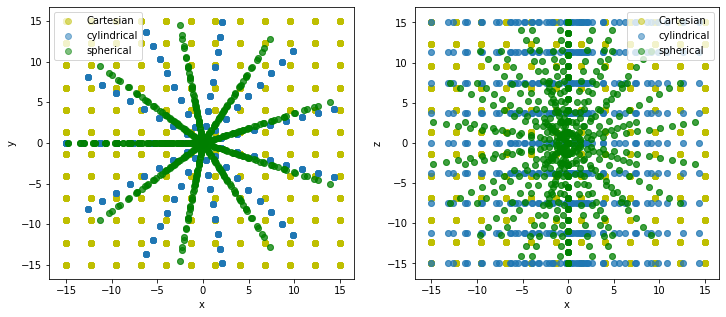

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(cartesian_grid.x, cartesian_grid.y, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.y, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.y, color='g', label='spherical', alpha=0.5)
plt.xlabel('x'); plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cartesian_grid.x, cartesian_grid.z, color='y', label='Cartesian', alpha=0.5)
plt.scatter(cylindrical_grid.x, cylindrical_grid.z, label='cylindrical', alpha=0.5)
plt.scatter(spherical_grid.x, spherical_grid.z, label='spherical', color='g', alpha=0.5)
plt.xlabel('x'); plt.ylabel('z')
plt.legend();




### Field object

As we mentioned before, [`Field`](https://imagine-code.readthedocs.io/en/latest/imagine.fields.html#module-imagine.fields.field) objects handle the calculation of any physical field.

Let us illustrate this by defining a *constant* cosmic ray electron number density field. 
This will of course have a single parameter: the constant number density of cosmic-ray electrons.

In [4]:
from imagine import GeneralField

class ConstantCRe(GeneralField):
    """Example: constant cosmic ray electron density"""
    field_name = 'constant_cre'
    field_type = 'cosmic_ray_electron_density'
    field_checklist = {'density_cm-3' : None}
    def get_field(self, parameters):
        return parameters['density_cm-3'] * np.ones(self.grid.shape)

With these few lines we have created our IMAGINE-compatible™ Field class!

The class-attribute `field_name` allows one to keep track of which model we have used to generate our field. 

The class attribute `field_type` **must** be one of types listed in the [conventions](https://imagine-code.readthedocs.io/en/latest/conventions.html) (and units and shapes should follow it too).  

Finally the `field_checklist` class-attribute is a dictionary whose keys are required parameters for this particular kind of field. The values in the dictionary can be used for specialized checking by some simulators (but can be left as `None` in the general case).

Finally, the function `get_field` actually computes the density field. Note that it takes the shape from a grid object which is stored in the `grid` attribute.

Let us now see this at work. First, let us creat an instance of `ConstantCRe`

In [5]:
cr_distribution = ConstantCRe(parameters={'density_cm-3':0.1},
                              grid=cartesian_grid)

IMAGINE will access the field procudes by `cr_distribution` through the `data` attribute. For example

In [6]:
cr_distribution.data[3:6,3:6,3:6]

array([[[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]],

       [[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]],

       [[0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1],
        [0.1, 0.1, 0.1]]])

If we now wanted to plot the cosmic ray electron density computed by this as a function of, say, spherical radius, this can be done in the following way

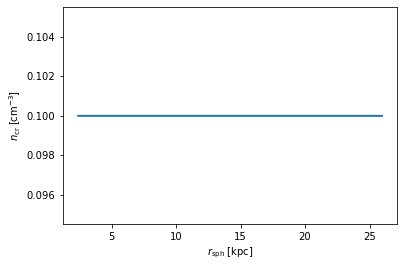

In [7]:
plt.plot(cr_distribution.grid.r_spherical.ravel(), 
         cr_distribution.data.ravel())
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$n_{\rm cr}\;[\rm cm^{-3}]$');

Let us do another 2 simple field examples: a constant magnetic field 
and a thermal electron density which decays exponentially with galaxy radius.

In [8]:
from imagine import GeneralField

class ExponentialElectrons(GeneralField):
    """Example: exponentially decaying thermal electron density """
    field_name = 'exp_ne'
    field_type = 'thermal_electron_density'
    field_checklist = {'central_density_cm-3': None, 'scale_radius_kpc': None}
    def get_field(self, parameters):
        R = self.grid.r_cylindrical
        Re = parameters['scale_radius_kpc']
        n0 = parameters['central_density_cm-3']
        return n0*np.exp(-np.abs(R/Re))
    
class ConstantB(GeneralField):
    """Example: constant magnetic field"""
    field_name = 'constantB'
    field_type = 'magnetic_field'
    field_checklist = {'Bx_muG': None, 'By_muG': None, 'Bz_muG': None}
    def get_field(self, parameters):
        Bx = parameters['Bx_muG']*np.ones(self.grid.shape)
        By = parameters['By_muG']*np.ones(self.grid.shape)
        Bz = parameters['Bz_muG']*np.ones(self.grid.shape)
        # The output must be of shape: (N,Nx,Ny,Nz) where 
        # iN=0 -> x, iN=1 -> y, iN=2 -> z
        return np.array([Bx, By, Bz])        

As before, we can generate a realisation of this

In [9]:
p = {'central_density_cm-3': 1.0, 'scale_radius_kpc': 3.3}
te_distribution = ExponentialElectrons(parameters=p, grid=cartesian_grid)
p = {'Bx_muG': 0, 'By_muG': 1., 'Bz_muG': 0.5}
B = ConstantB(parameters=p, grid=cartesian_grid)

And inspect how it went

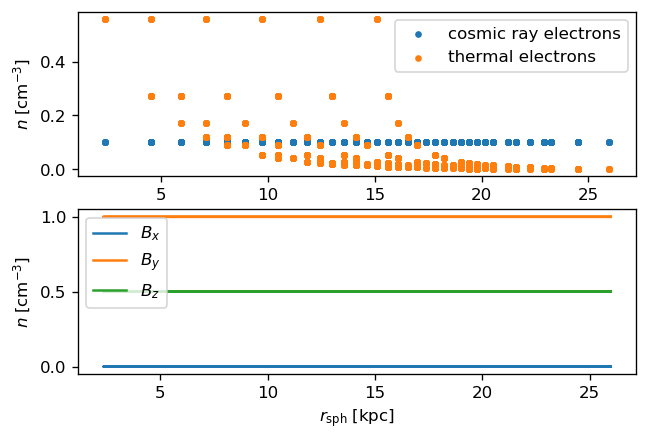

In [10]:
r_spherical = cr_distribution.grid.r_spherical.ravel()

plt.figure(dpi=120); plt.subplot(2,1,1)
plt.scatter(r_spherical, cr_distribution.data.ravel(), 
            label='cosmic ray electrons', marker='.')
plt.scatter(r_spherical, te_distribution.data.ravel(), 
            label='thermal electrons', marker='.')
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$n\;[\rm cm^{-3}]$')
plt.legend();

plt.subplot(2,1,2)
for i, name in enumerate(['x','y','z']):
    plt.plot(r_spherical, B.data[i,...].ravel(), 
             label='$B_{}$'.format(name))
plt.xlabel(r'$r_{\rm sph}\;[\rm kpc]$'); plt.ylabel(r'$n\;[\rm cm^{-3}]$')
plt.legend();



### Field factory

Associated with each Field class we need to prepare a FieldFactory class, which will take care (separately) of the scaling of parameter ranges. This is can done through the 
following simple templates

In [11]:
from imagine import GeneralFieldFactory

class ConstantCRe_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantCRe
        self.default_parameters = {'density_cm': 0.5}
        self.parameter_ranges = {'density_cm': [0, 10]}
        
class ExponentialElectrons_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ExponentialElectrons
        self.default_parameters = {'central_density_cm-3': 1,
                                   'scale_radius_kpc': 3.0}
        self.parameter_ranges = {'central_density_cm-3': [0,10],
                                 'scale_radius_kpc': [0,10]}
        
class ConstantB_Factory(GeneralFieldFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.field_class = ConstantB
        self.default_parameters = {'Bx_muG': 0.0,
                                   'By_muG': 0.0,
                                   'Bz_muG': 0.0}
        self.parameter_ranges = {'Bx_muG': [-30, 30],
                                 'By_muG': [-30, 30],
                                 'Bz_muG': [-10, 10]}

We can now create instances of any of these. Which can return Field objects through the 
`generate` method.

In [12]:
Bfactory = ConstantB_Factory(grid=cartesian_grid)
newB = Bfactory.generate()
newB.field_name, newB.parameters

('constantB', {'Bx_muG': 0.0, 'By_muG': 0.0, 'Bz_muG': 0.0})

The parameters were all set to their default values.
In practice, before the factory object is used, the pipeline 
first sets a list of *active* parameters 
(any inactive parameters keeps its default value)

In [13]:
Bfactory.active_parameters = ['Bx_muG']

The `generate` method can then be called with a dictionary containing *scaled* *dimensionless* variables as values

In [14]:
dimensionless_scaled_variables = {'Bx_muG': 0.7}  # This is NOT 0.5 microGauss!
newB = Bfactory.generate(variables=dimensionless_scaled_variables)
newB.parameters

{'Bx_muG': 12.0, 'By_muG': 0.0, 'Bz_muG': 0.0}

We see that the value corresponds to the 70% of the range between -30 and 30 \muG

## Observables and Observable dictionaries



## Simulator

[Simulator objects](https://imagine-code.readthedocs.io/en/latest/imagine.simulators.html)
are responsible for converting into observables the physical quantities computed/stored by the Field objects. 
